This file uses the landing simulation code and displays trackpy locate and batch, as well as the moving average background correction. 

In [48]:
import numpy as np
import math
import matplotlib.pyplot as plt
import time

class Landing_Flashes:
    """
    Generates a stack of images corresponding to landing of Brownian particles, assuming each particles lands in single frame (no time trace).

    Parameters
    ----------
    :fov: [width, height] of the desired image that contains these particles
    :bgframe: stationary background image given as input
    Returns
    -------
    :return: .loca: intended location of the particles (with sub-pixel resolution)
             .stack: a stack of images with specified noise and particles displaced accordingly
    """
    def __init__(self, seed = 500, fov = [300, 200], nframes=30, numpar = 20, signal = 10.0, sizevar = 0.3, normalvar = False, noise = 0.01, bgframe = [None], dark = 10, psize = 6, unevenIllumination = False, irefmode = 2):
        # camera and monitor parameters
        self.seed = seed #seeding for the particles, to generate the same set each time
        self.xfov, self.yfov = fov
        self.numpar = numpar # Desired number of landing particles
        self.nframes = nframes # Desired number of recorded images
        self.signal = signal # brightness for each particle
        self.sizevar = sizevar # width of the size distribution assuming a square histogram
        self.noise = noise # background noise
        self.psize = psize # diameter of each particle in the image, currently must be integer
        self.parlist = []  # ground truth for the particle location
        
        
        if unevenIllumination:
            self.iref = self.genIref(irefmode)
        else:
            self.iref = np.ones(fov)

        self.psf = self.initPSF(psize)
        if bgframe == [None]:
            self.bg = self.genBG(dark, noise)
        else:
            self.bg = bgframe
        
        np.random.seed(self.seed)
        ts = np.random.uniform(0, numpar+1, size=(self.nframes, 1))
        self.nlanded = np.sort(ts.astype(int), axis=0)
        self.numpar = np.max(self.nlanded)
        if normalvar:
            self.loca = self.initLocations_normal()
        else:
            self.loca = self.initLocations()

    def genBG(self, dar, noi):
        """
        generates constant noisy background with extra dark signal
        """
        np.random.seed(self.seed)
        bg = np.random.poisson(noi, size = (self.xfov, self.yfov)) + dar
        ffbg = np.fft.rfft2(bg)
        max_freq = int(self.xfov / self.psize)
        ffbg[max_freq:, max_freq:] = 0
        bg = abs(np.fft.irfft2(ffbg))

        return bg

    def genIref(self, md):
        """
        generates uneven illumination pattern
        """
        cox, coy = np.meshgrid(np.arange(self.xfov)/self.xfov, np.arange(self.yfov)/self.yfov, indexing='ij')
        ir = self.noise*np.sin(2*np.pi*md*(cox+coy))+self.signal

        return ir
        
    def initPSF(self, p):
        psf = np.zeros((2*p,2*p))
        for n in range(p):
            for m in range(p):
                psf[p+n,p+m] = psf[p-n-1,p+m] = psf[p+n,p-m-1] = psf[p-n-1,p-m-1] = np.exp(-np.sqrt(n**2+m**2)/p)
        return psf
        

    def initLocations(self):
        # initializes the random location of numpar particles in the frame. one can add more paramaters like intensity
        # and PSF distribution if necessary
        np.random.seed(self.seed)
        p = self.psize
        parx = np.random.uniform(2*p, self.xfov-2*p, size=(self.numpar, 1))
        pary = np.random.uniform(2*p, self.yfov-2*p, size=(self.numpar, 1))
        pari = np.random.uniform(self.signal*(1-self.sizevar/2), self.signal*(1+self.sizevar/2), size=(self.numpar, 1))

        lp = np.concatenate((parx, pary, pari), axis=1)
        self.parlist = lp

        return lp

    def initLocations_normal(self):
        # initializes the random location of numpar particles in the frame. one can add more paramaters like intensity
        # and PSF distribution if necessary
        np.random.seed(self.seed)
        p = self.psize
        parx = np.random.uniform(2*p, self.xfov-2*p, size=(self.numpar, 1))
        pary = np.random.uniform(2*p, self.yfov-2*p, size=(self.numpar, 1))
        pari = np.random.normal(self.signal, self.sizevar, size=(self.numpar, 1))

        lp = np.concatenate((parx, pary, pari), axis=1)
        self.parlist = lp

        return lp
    
    def genImage(self,npar):
        """
        :return: generated image with specified position in self.loca up to particle number n
        """
        simimage = np.copy(self.bg)
        psize = self.psize
        if npar > self.numpar:
            m = self.numpar
        else:
            m = int(npar)
        for n in range(m):
            x = int(self.loca[n,0])
            y = int(self.loca[n,1])
            simimage[x-psize:x+psize, y-psize:y+psize] = simimage[x-psize:x+psize, y-psize:y+psize] + self.psf * self.loca[n,2]

        simimage = np.multiply(simimage,self.iref)
        return simimage


    def genStack(self):
        """
        Using all the above methods in this class, this method only iterates enough to create a stack of synthetic frames
        that can be analyzed later

        :param nframes: number of frames to generate
        :return: simulated data
        """
        np.random.seed(self.seed)
        numpar = self.numpar
        nf = self.nframes
        data = np.zeros((nf, self.xfov, self.yfov))
        for n in range(nf):
            l = np.random.poisson(self.noise, size = (self.xfov, self.yfov))
            npar = self.nlanded[n]
            data[n,:,:] = (self.genImage(npar) + l)

        return data

        #Changed it to (n,x,y) format

Enter variables for particle simulation

50


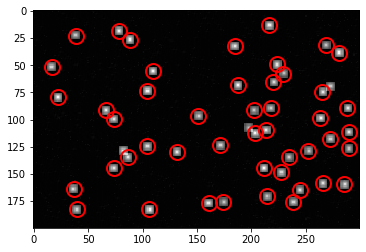

47
Not all particles are located, perhaps change some parameters


In [49]:
nf = 100 # number of frames
meas = Landing_Flashes(fov=[200,300], numpar = 50, nframes = nf, signal = 20, sizevar=0.3, dark = 3, psize = 4, unevenIllumination = False)
# =======================================
plis = meas.parlist
list1 = plis[:,2]
numpar = len(list1)
print(numpar)

# uncomment lines below to save simulated frames to a folder of choice
sig = meas.genStack()
im = plt.imshow(sig[-1,:,:]) # show direct the last frame

# for i in range(nf):
#     plt.imshow(sig[i,:,:]) # show each image with title
#     plt.title(f'Frame no.{i}')
#     time.sleep(0.01)
# #     save_results_to = 'C:/Users/brugg/Imagesnew/simulation/'
# #     plt.savefig(save_results_to + f'image{i}.png', dpi=300)
#     plt.show()

#Quick particle count on last frame
f = trackpy.locate(sig[-1,:,:], 9, minmass = 10, invert = False)
trackpy.annotate(f, sig[-1,:,:]);
print(len(f['mass']))
if len(f['mass']) == numpar:
    print('Great work, all particles are found')
elif len(f['mass']) < numpar:
    print('Not all particles are located, perhaps change some parameters')
else:
    print('Oops, more particles are found than started. This is not posible.')



Use moving average bg to see the landings per frame

(99, 200, 300)


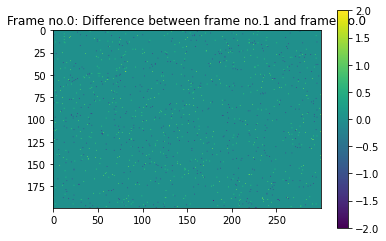

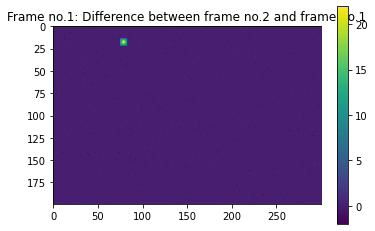

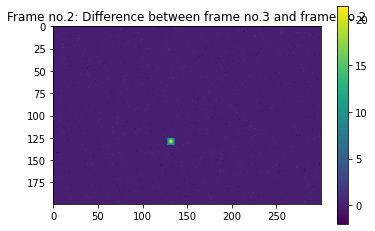

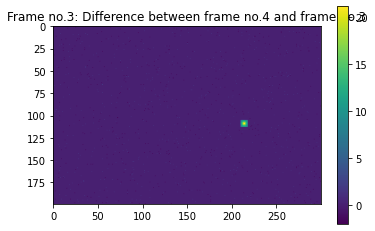

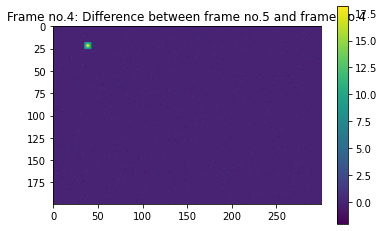

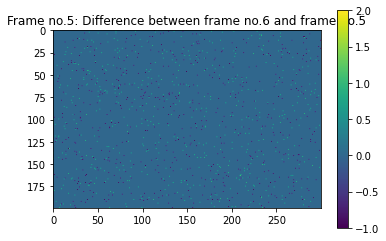

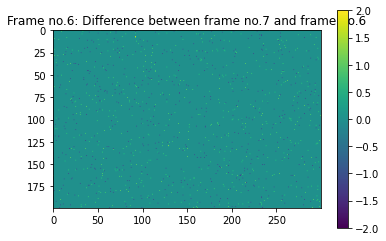

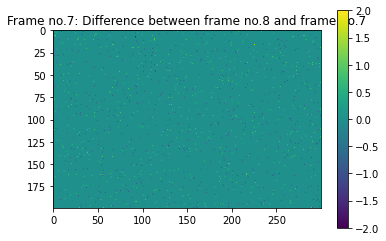

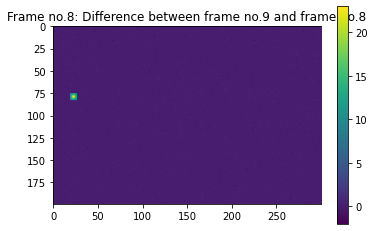

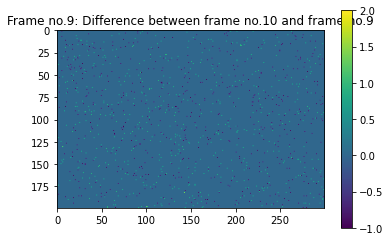

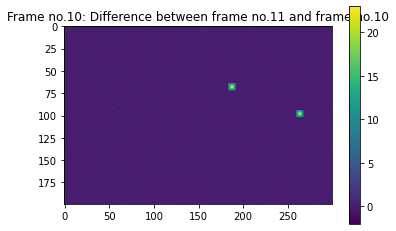

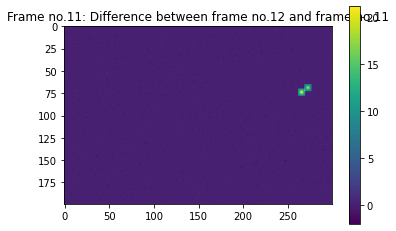

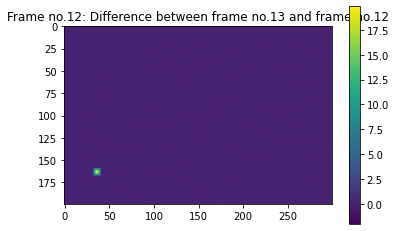

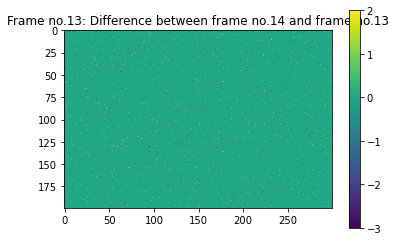

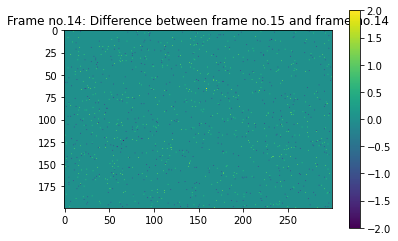

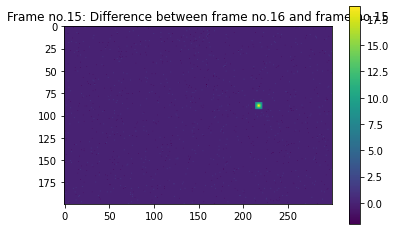

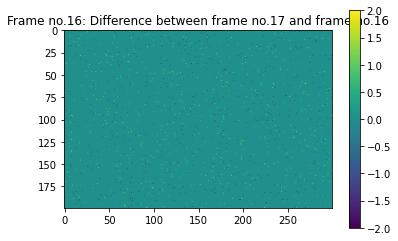

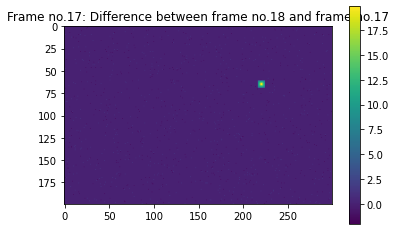

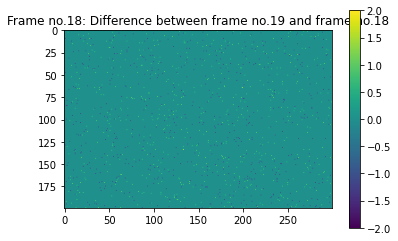

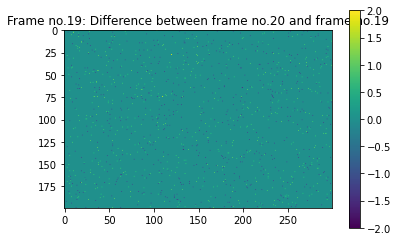

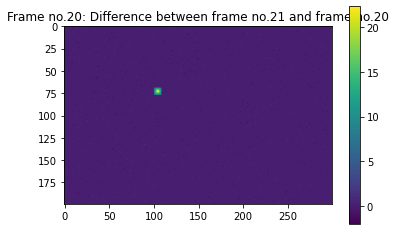

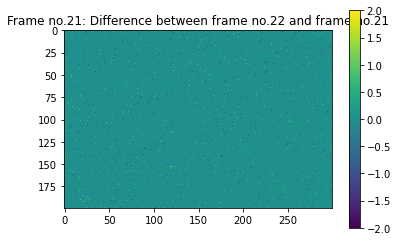

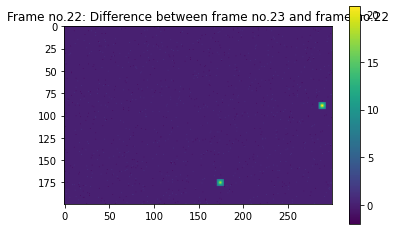

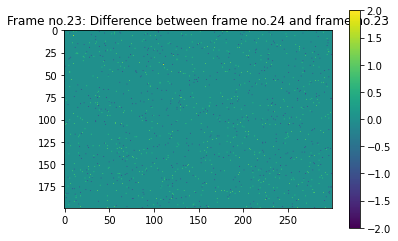

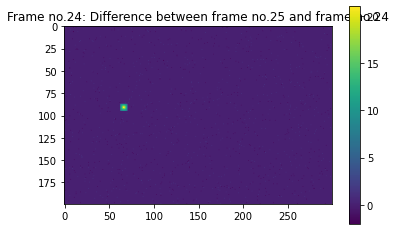

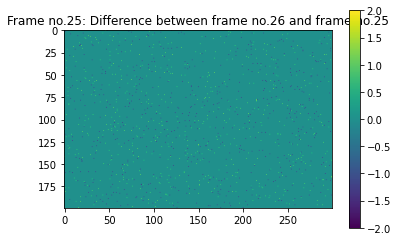

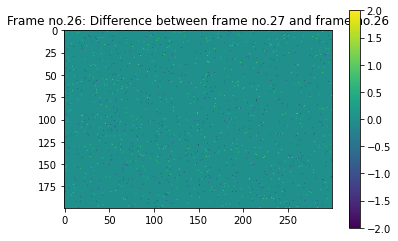

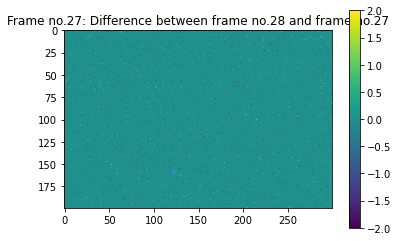

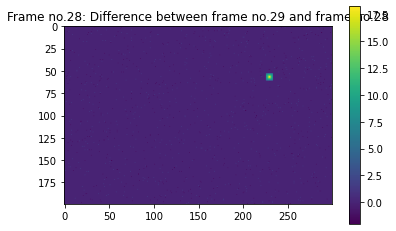

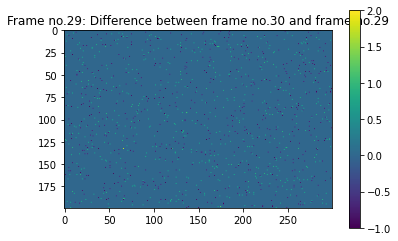

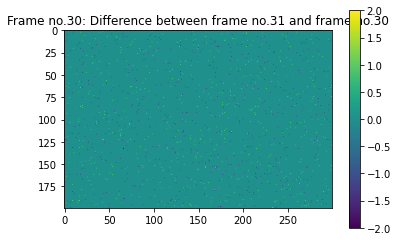

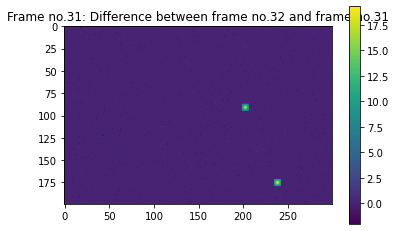

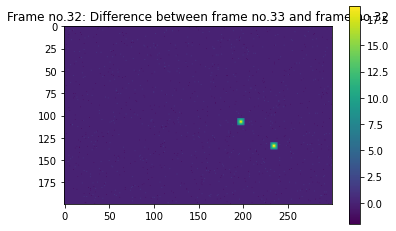

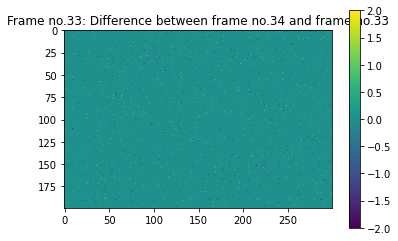

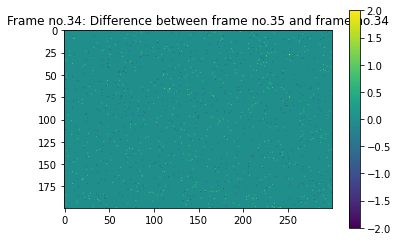

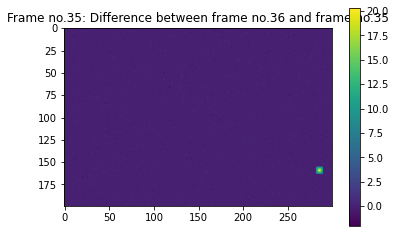

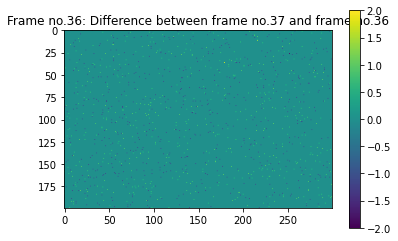

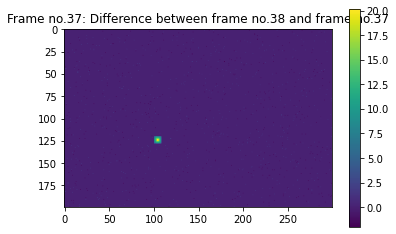

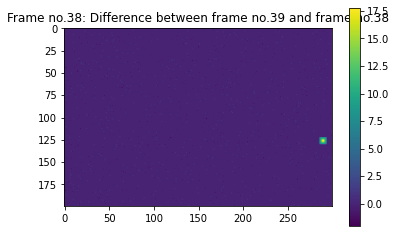

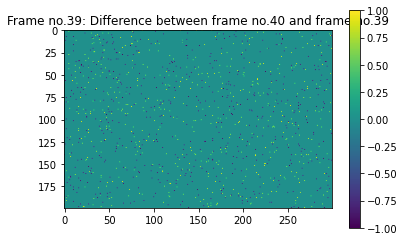

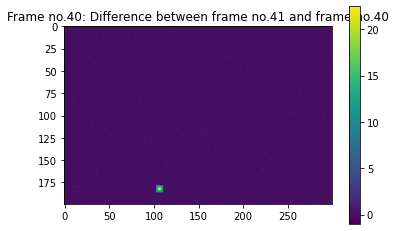

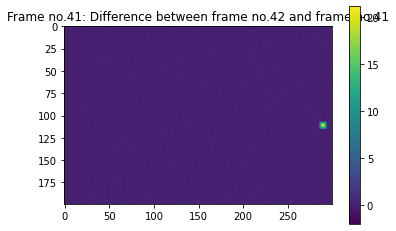

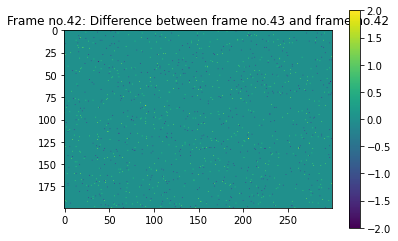

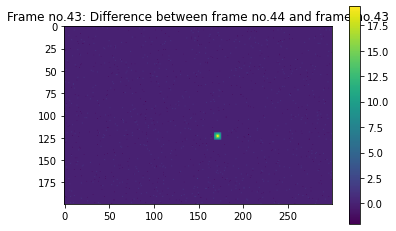

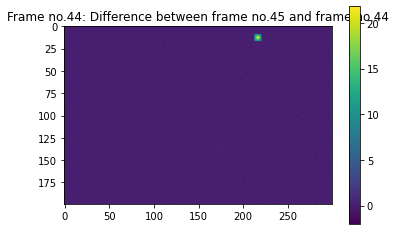

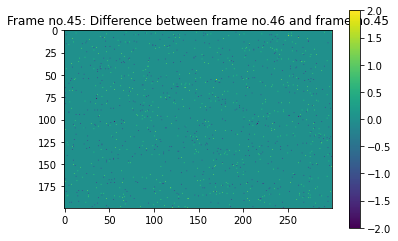

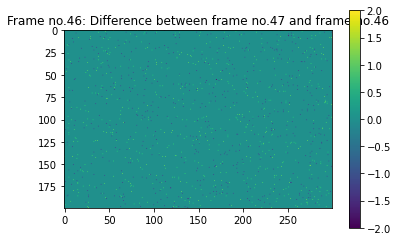

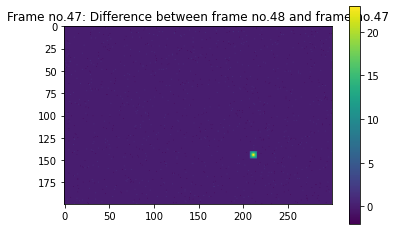

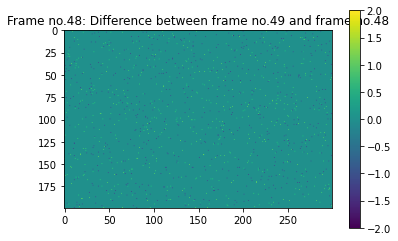

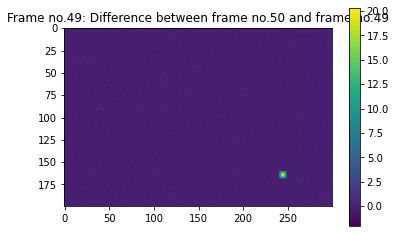

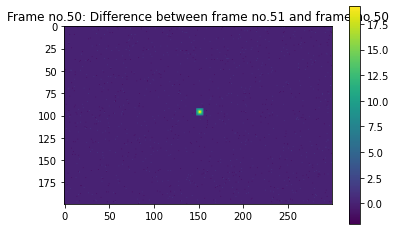

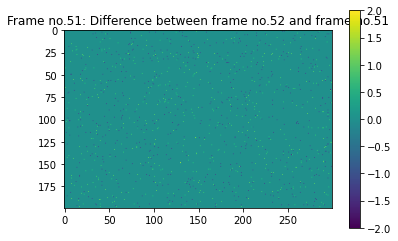

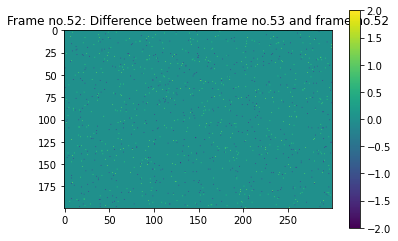

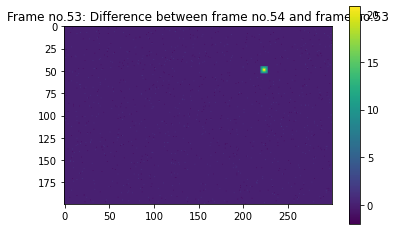

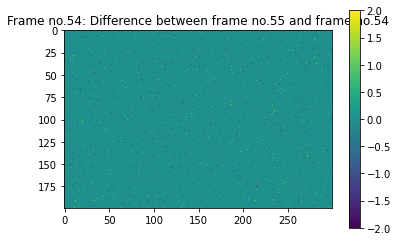

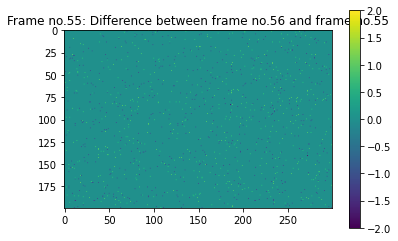

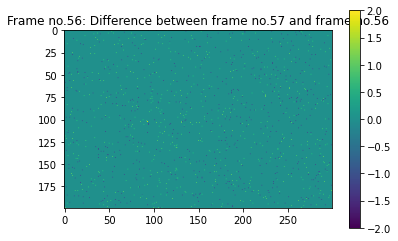

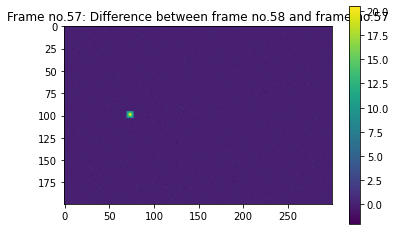

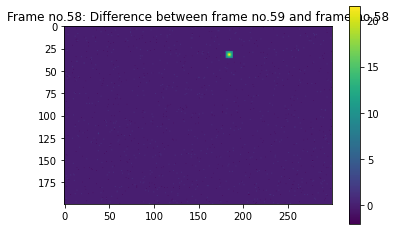

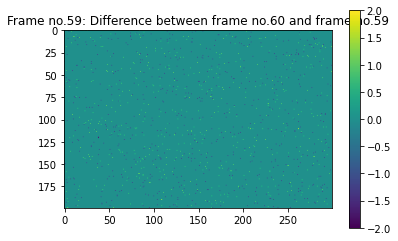

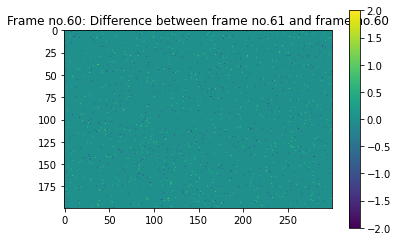

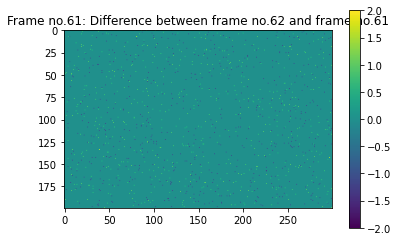

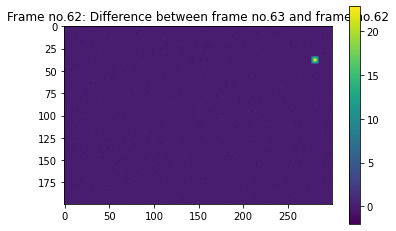

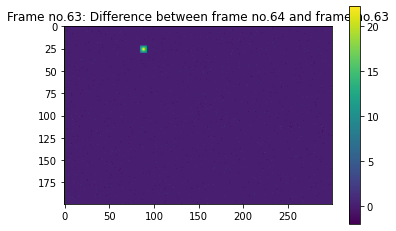

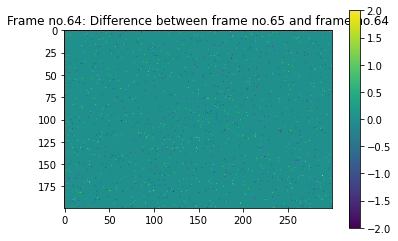

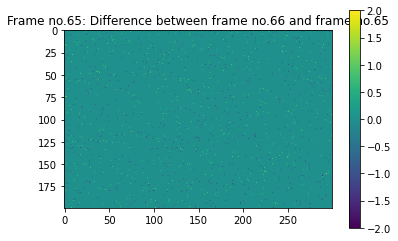

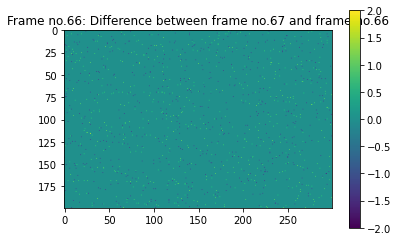

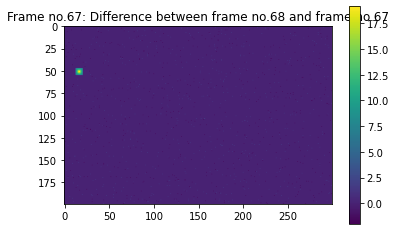

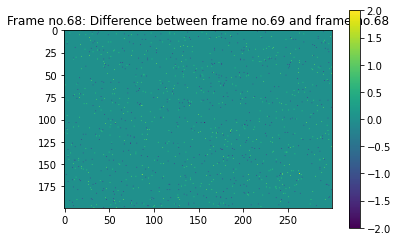

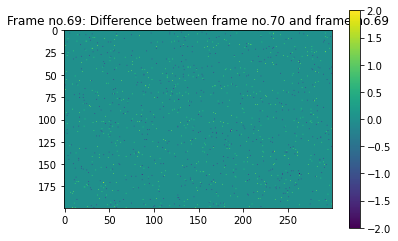

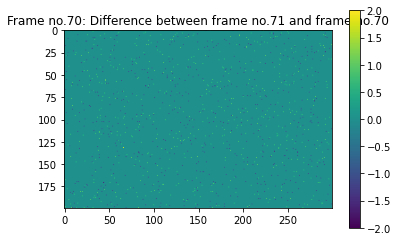

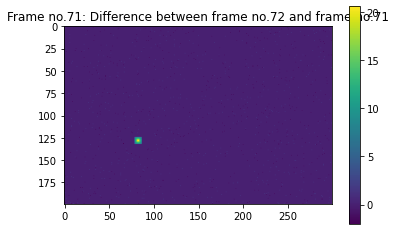

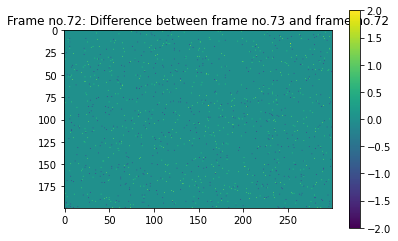

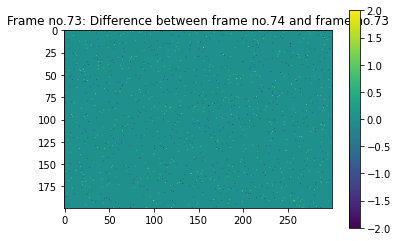

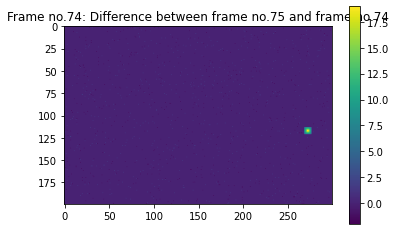

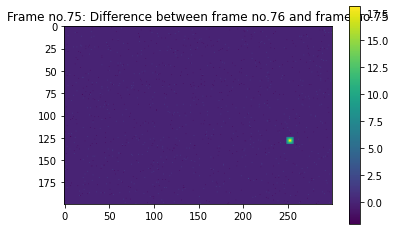

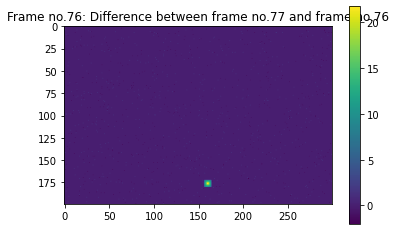

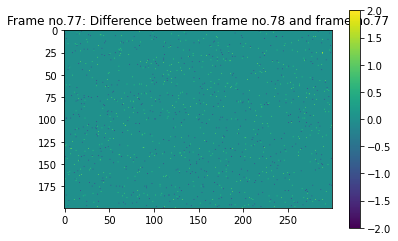

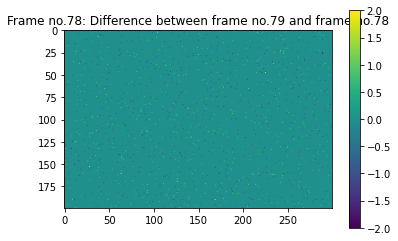

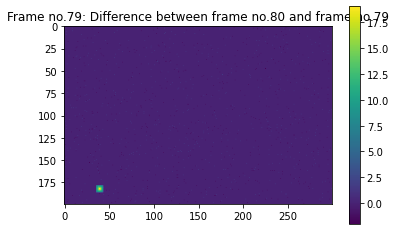

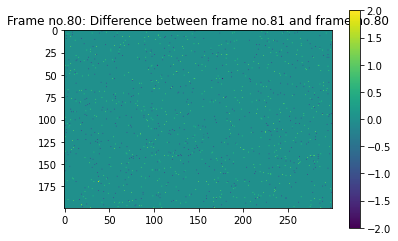

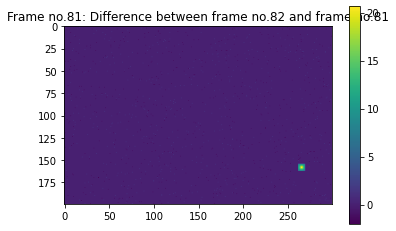

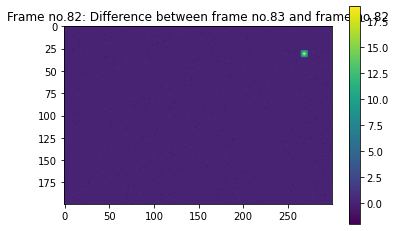

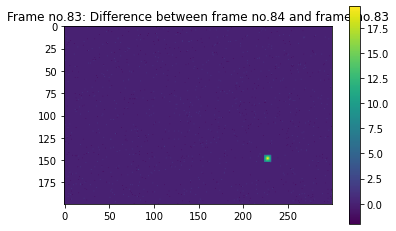

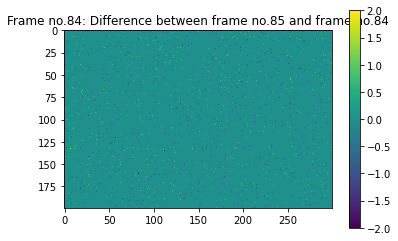

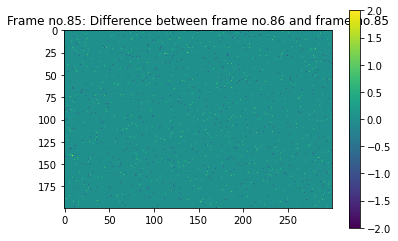

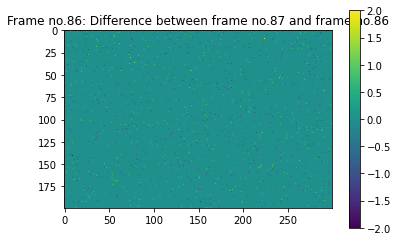

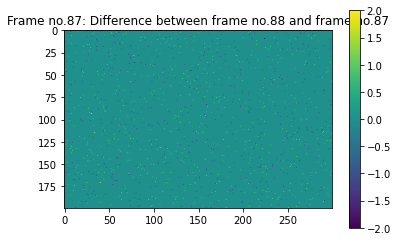

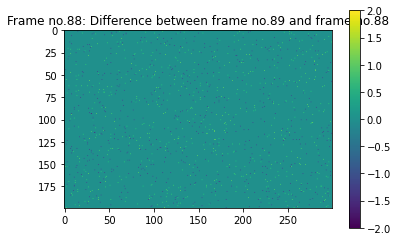

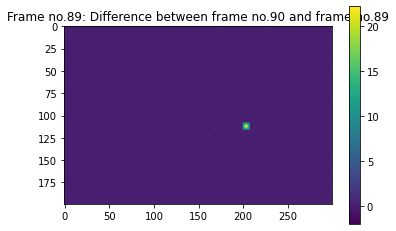

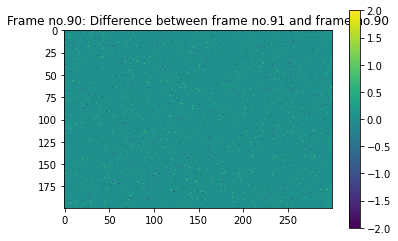

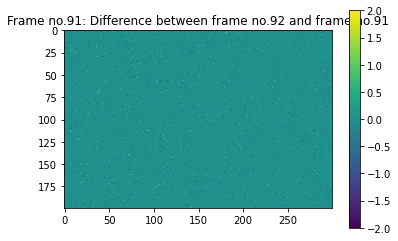

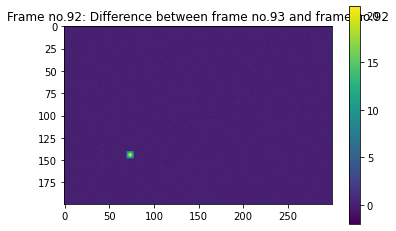

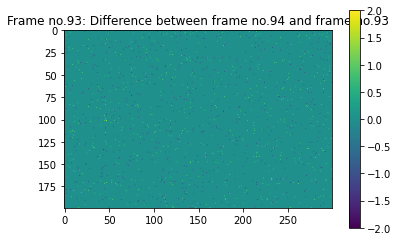

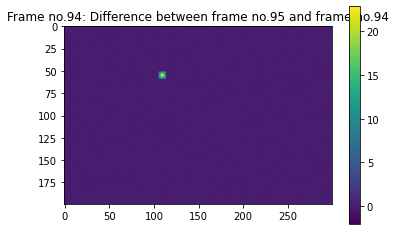

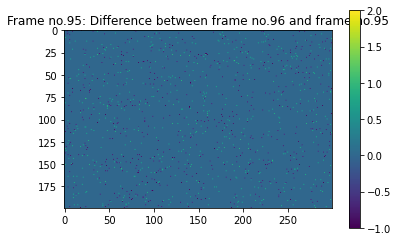

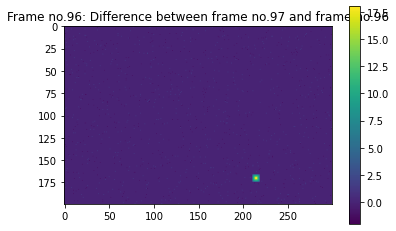

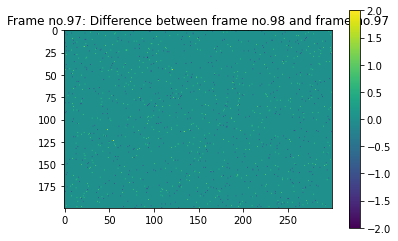

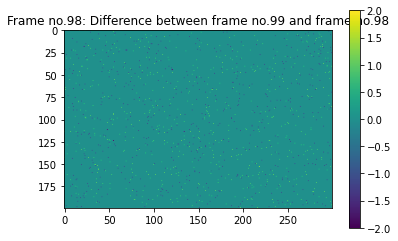

In [50]:
startframe = 0
endframe = nf 
startframe2 = 1 # +1 for accounting for the moving average
endframe2 = endframe-startframe

bgcorrected = sig[startframe2:endframe2,:,:] - np.mean([sig[startframe2-1:endframe2-1,:,:]], axis = 0)
print(bgcorrected.shape) # to check the shape of the array(frames,x,y)

for i in np.arange(0,bgcorrected.shape[0]):
    im=plt.imshow(bgcorrected[i,:,:])
    plt.title(f'Frame no.{i}: Difference between frame no.{i+1} and frame no.{i}')
    plt.colorbar()
    plt.pause(0.01)
    plt.show()



Use trackpy locate and batch on the frame-per-frame series from above

C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


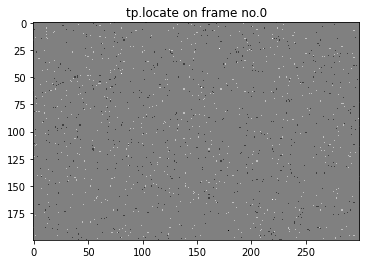

No particles located in this frame!


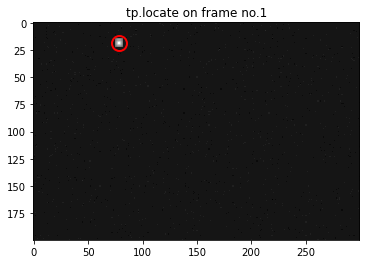

A non-zero value!, namely 1


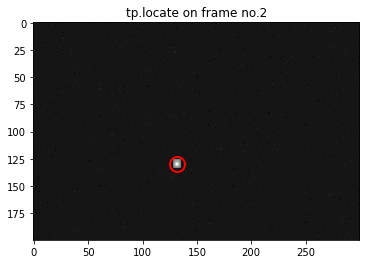

A non-zero value!, namely 1


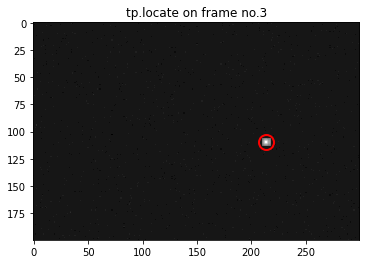

A non-zero value!, namely 1


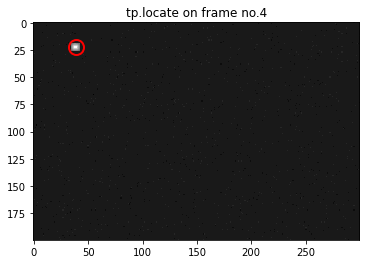

A non-zero value!, namely 1


C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


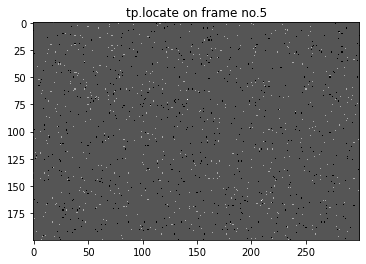

No particles located in this frame!


C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


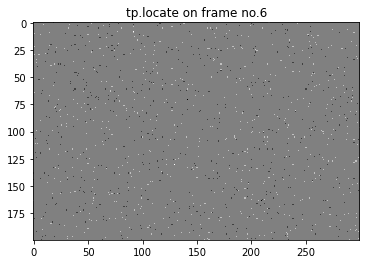

No particles located in this frame!


C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


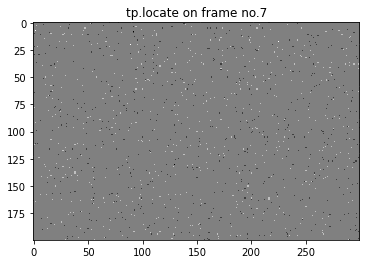

No particles located in this frame!


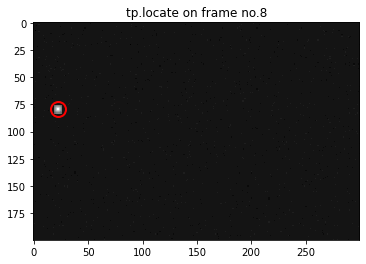

A non-zero value!, namely 1


C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


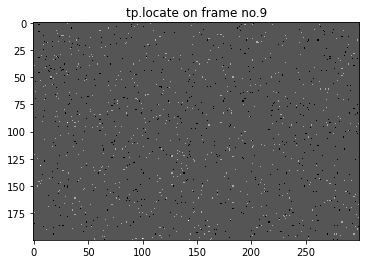

No particles located in this frame!


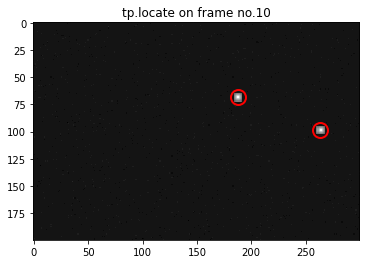

A non-zero value!, namely 2


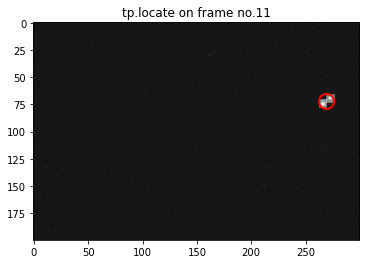

A non-zero value!, namely 1


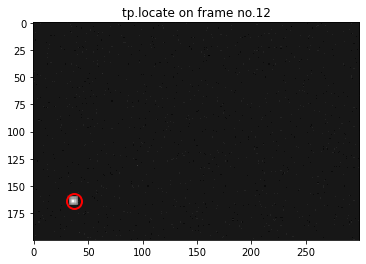

A non-zero value!, namely 1


C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


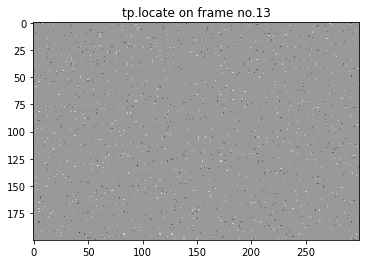

No particles located in this frame!


C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


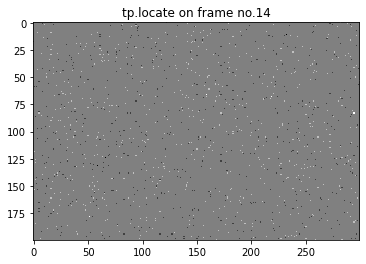

No particles located in this frame!


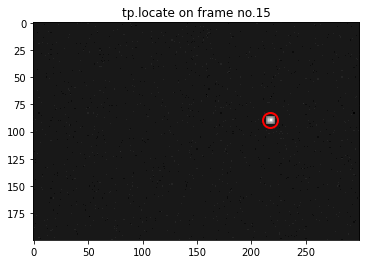

A non-zero value!, namely 1


C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


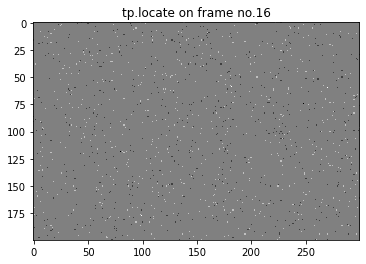

No particles located in this frame!


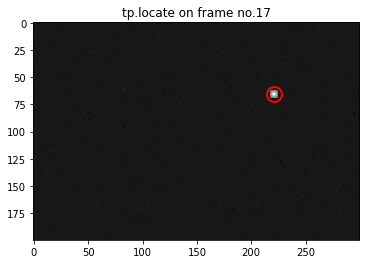

A non-zero value!, namely 1


C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


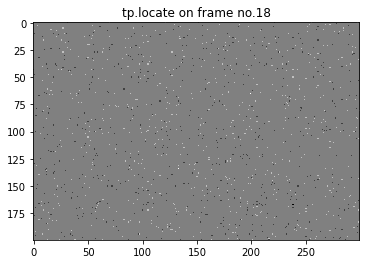

No particles located in this frame!


C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


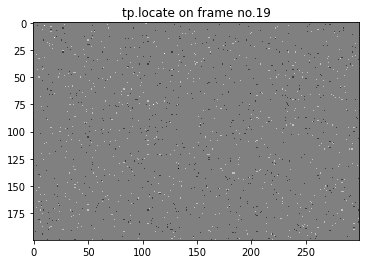

No particles located in this frame!


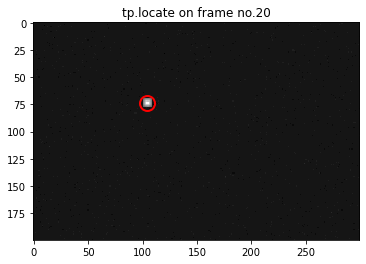

A non-zero value!, namely 1


C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


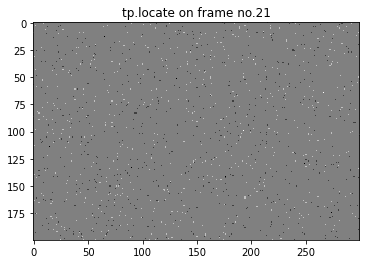

No particles located in this frame!


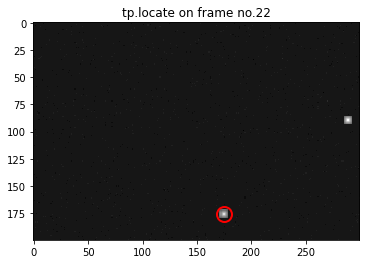

A non-zero value!, namely 1


C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


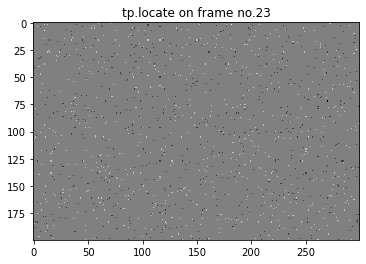

No particles located in this frame!


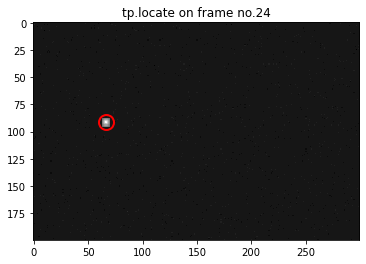

A non-zero value!, namely 1


C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


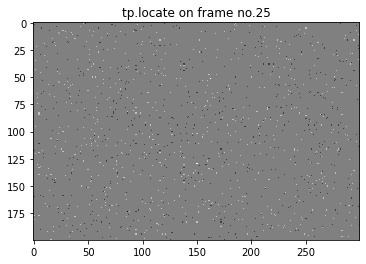

No particles located in this frame!


C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


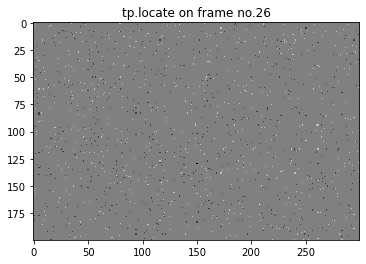

No particles located in this frame!


C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


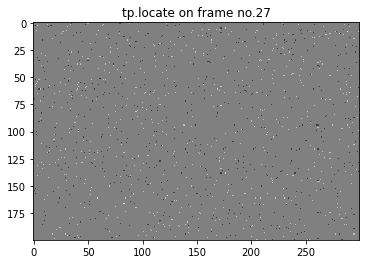

No particles located in this frame!


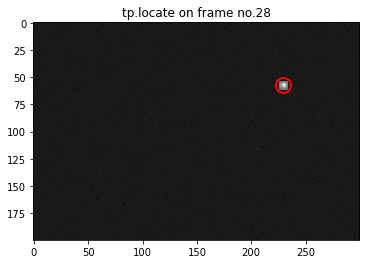

A non-zero value!, namely 1


C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


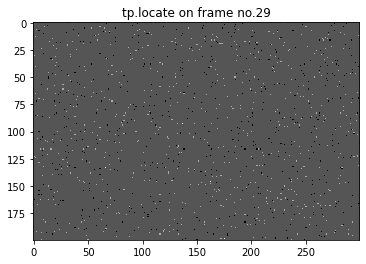

No particles located in this frame!


C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


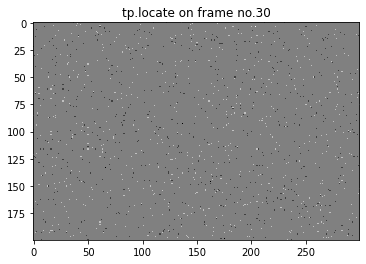

No particles located in this frame!


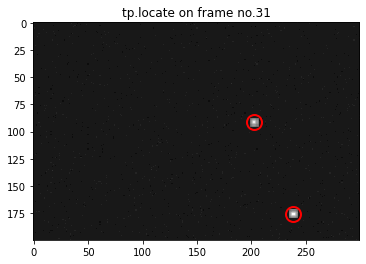

A non-zero value!, namely 2


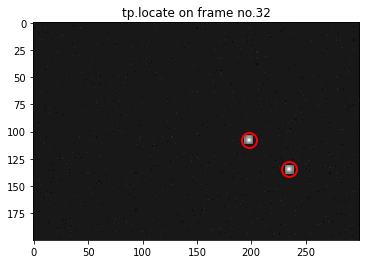

A non-zero value!, namely 2


C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


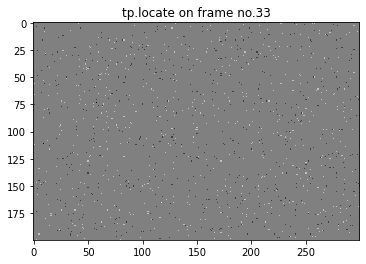

No particles located in this frame!


C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


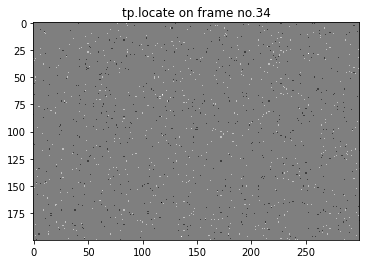

No particles located in this frame!


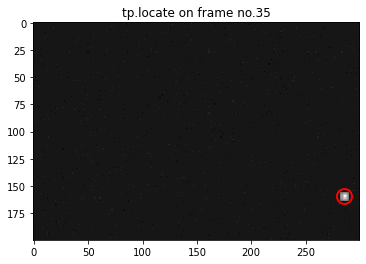

A non-zero value!, namely 1


C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


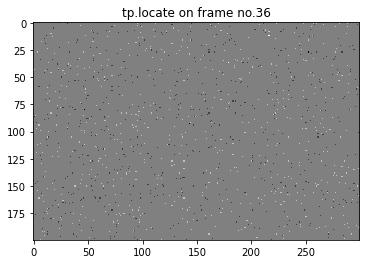

No particles located in this frame!


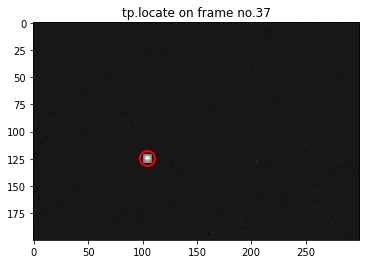

A non-zero value!, namely 1


C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


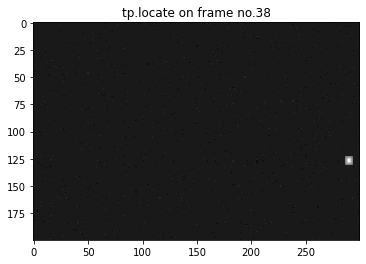

No particles located in this frame!


C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


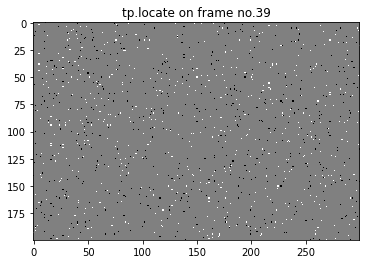

No particles located in this frame!


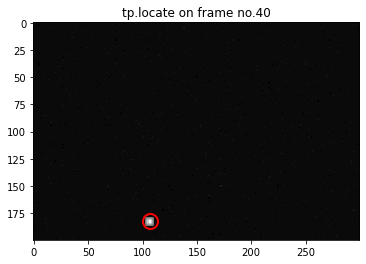

A non-zero value!, namely 1


C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


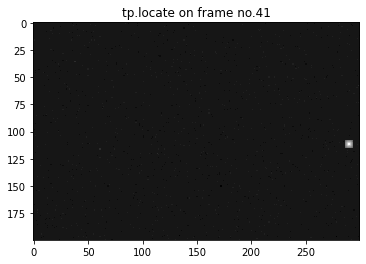

No particles located in this frame!


C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


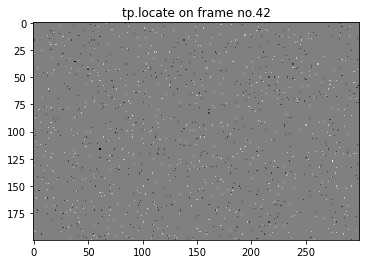

No particles located in this frame!


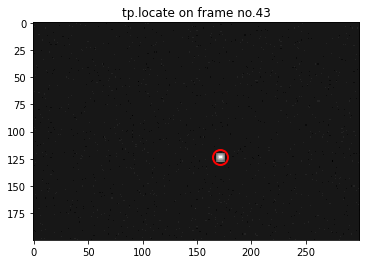

A non-zero value!, namely 1


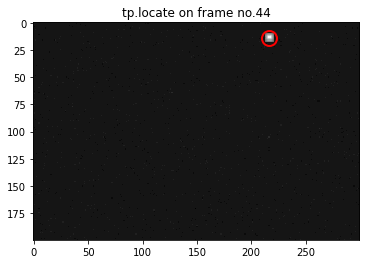

A non-zero value!, namely 1


C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


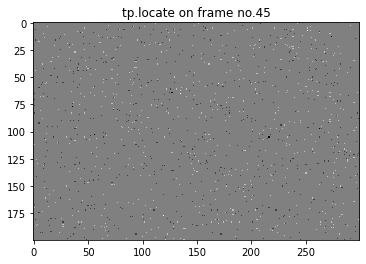

No particles located in this frame!


C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


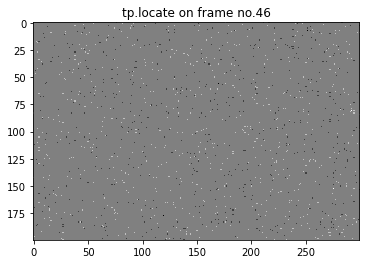

No particles located in this frame!


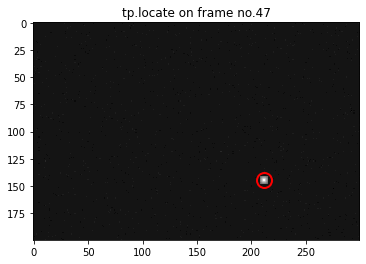

A non-zero value!, namely 1


C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


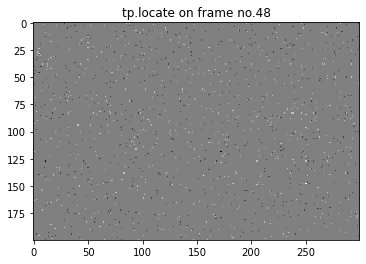

No particles located in this frame!


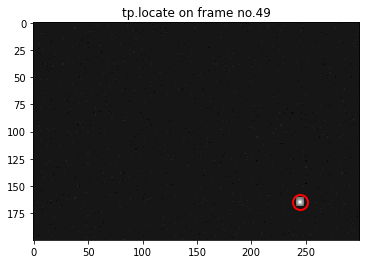

A non-zero value!, namely 1


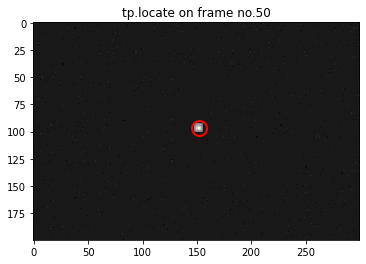

A non-zero value!, namely 1


C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


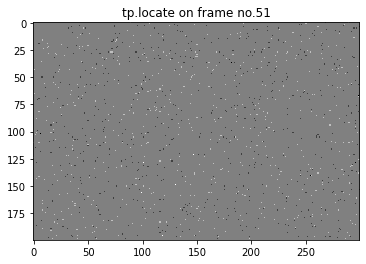

No particles located in this frame!


C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


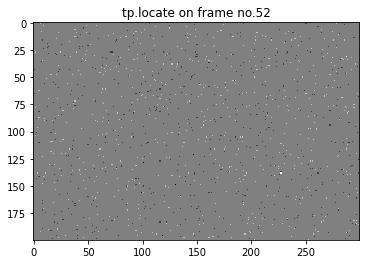

No particles located in this frame!


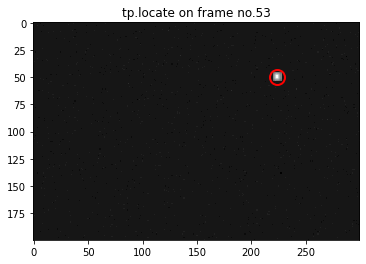

A non-zero value!, namely 1


C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


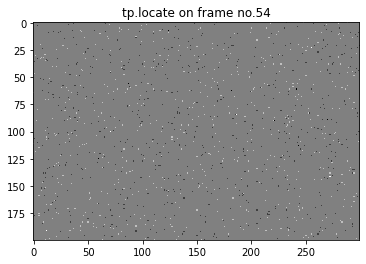

No particles located in this frame!


C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


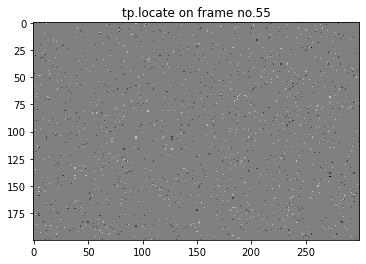

No particles located in this frame!


C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


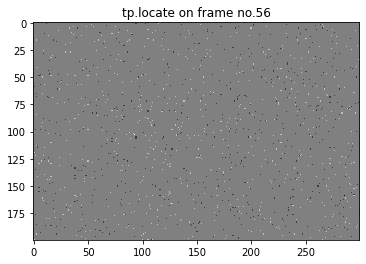

No particles located in this frame!


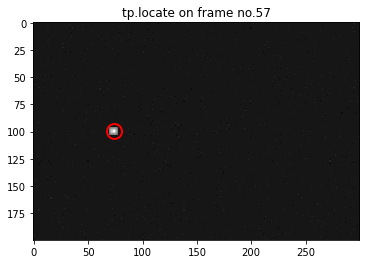

A non-zero value!, namely 1


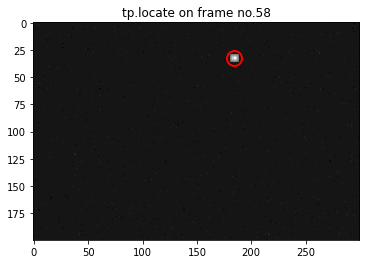

A non-zero value!, namely 1


C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


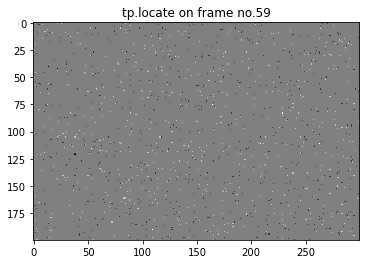

No particles located in this frame!


C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


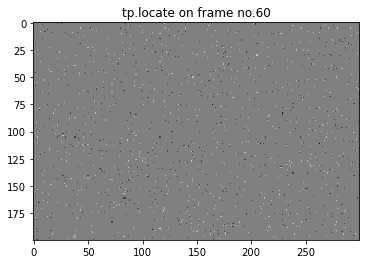

No particles located in this frame!


C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


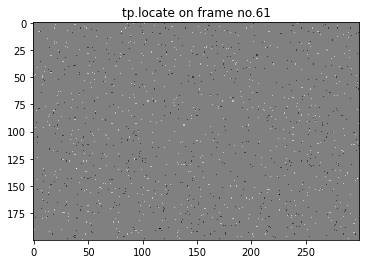

No particles located in this frame!


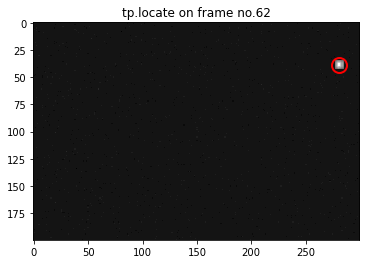

A non-zero value!, namely 1


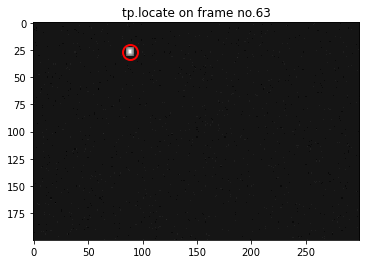

A non-zero value!, namely 1


C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


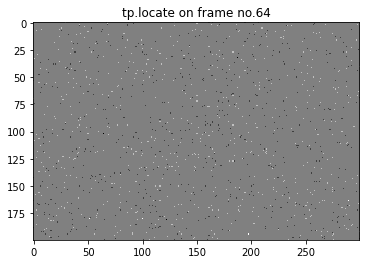

No particles located in this frame!


C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


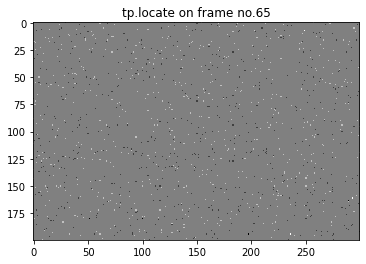

No particles located in this frame!


C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


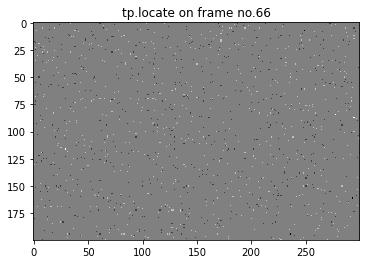

No particles located in this frame!


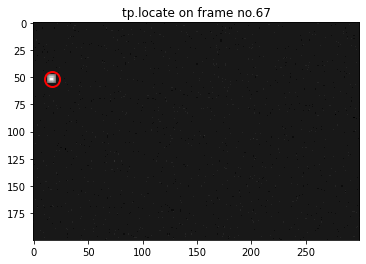

A non-zero value!, namely 1


C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


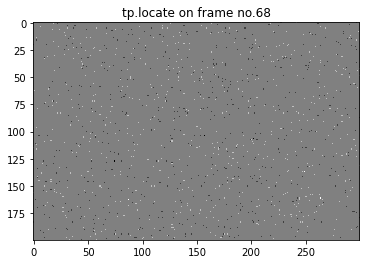

No particles located in this frame!


C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


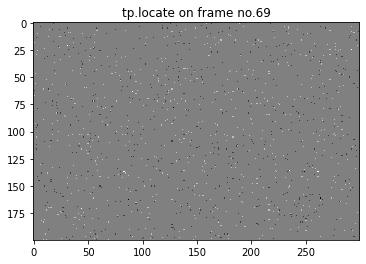

No particles located in this frame!


C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


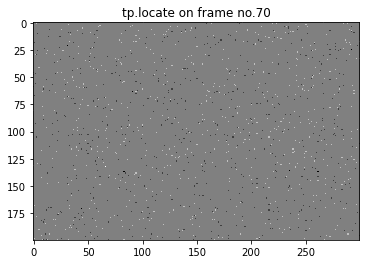

No particles located in this frame!


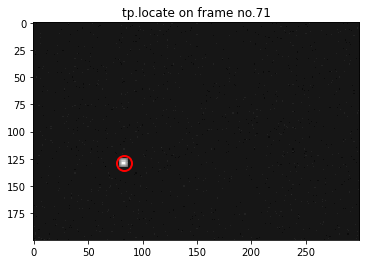

A non-zero value!, namely 1


C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


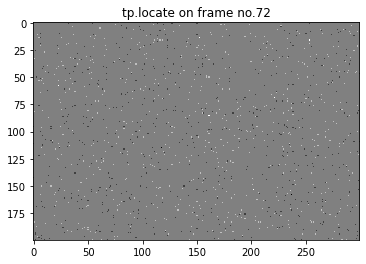

No particles located in this frame!


C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


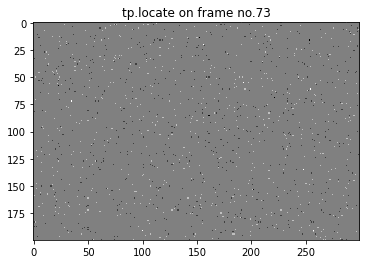

No particles located in this frame!


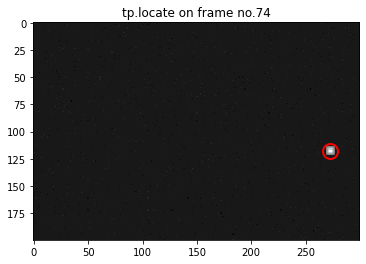

A non-zero value!, namely 1


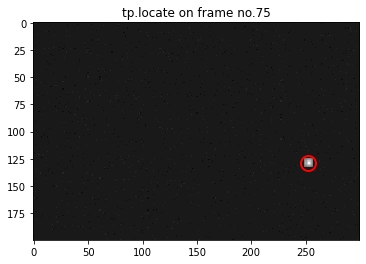

A non-zero value!, namely 1


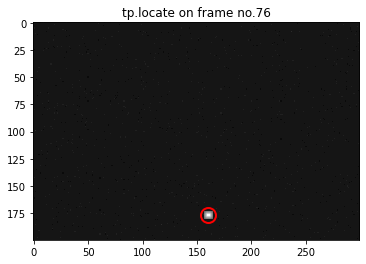

A non-zero value!, namely 1


C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


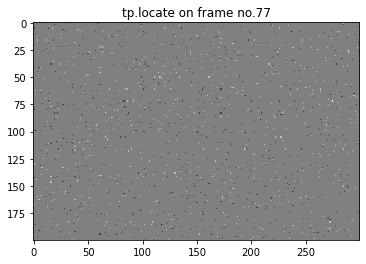

No particles located in this frame!


C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


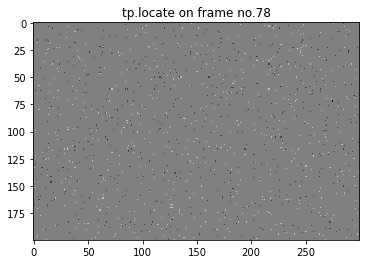

No particles located in this frame!


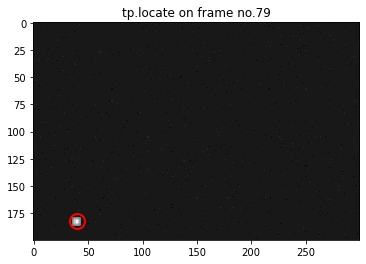

A non-zero value!, namely 1


C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


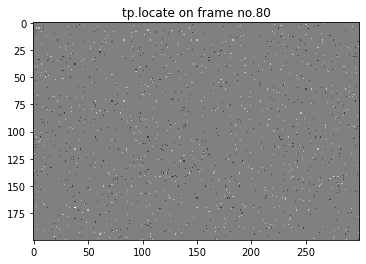

No particles located in this frame!


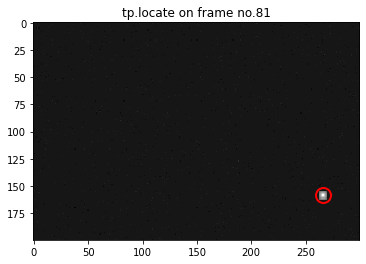

A non-zero value!, namely 1


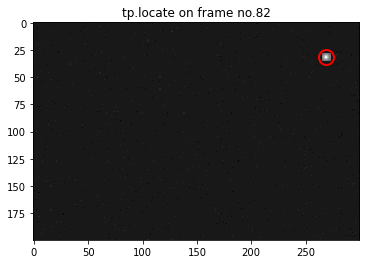

A non-zero value!, namely 1


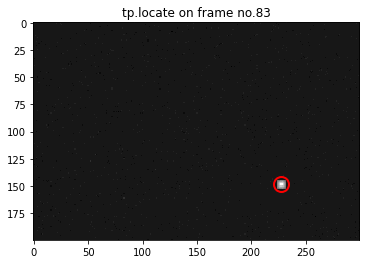

A non-zero value!, namely 1


C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


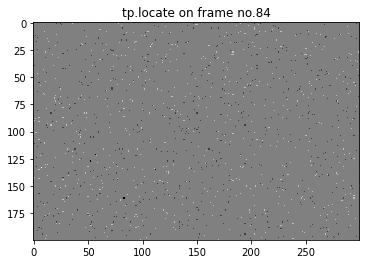

No particles located in this frame!


C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


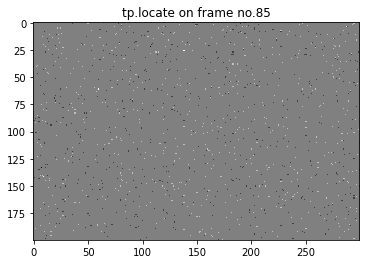

No particles located in this frame!


C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


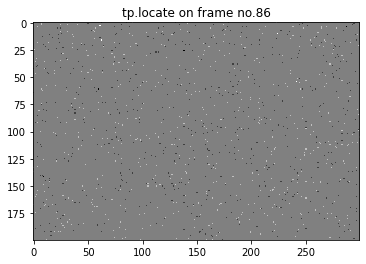

No particles located in this frame!


C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


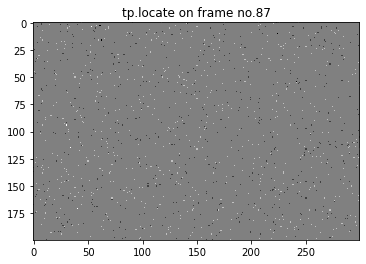

No particles located in this frame!


C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


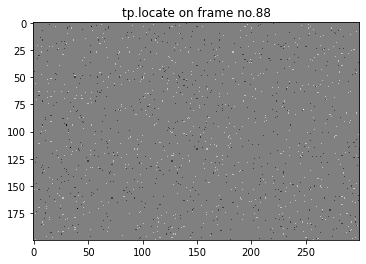

No particles located in this frame!


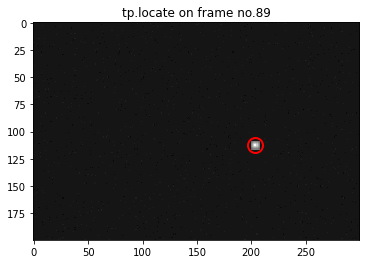

A non-zero value!, namely 1


C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


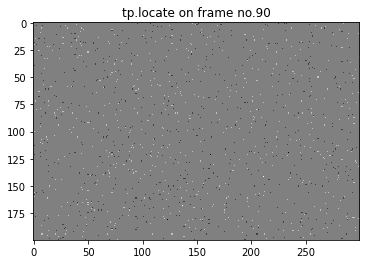

No particles located in this frame!


C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


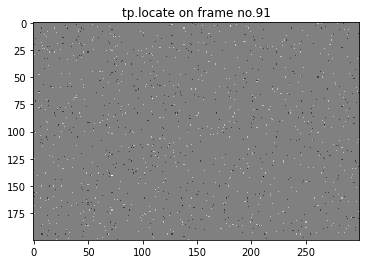

No particles located in this frame!


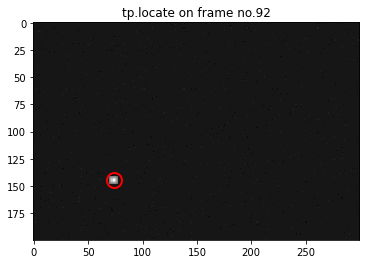

A non-zero value!, namely 1


C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


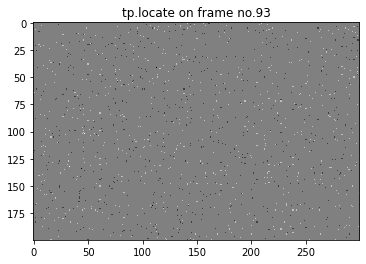

No particles located in this frame!


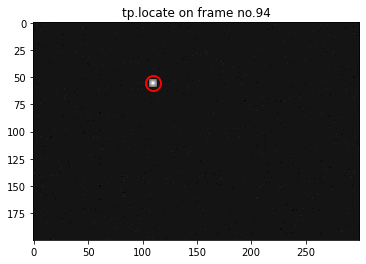

A non-zero value!, namely 1


C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


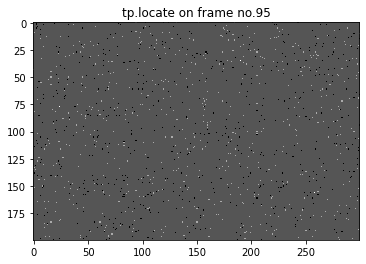

No particles located in this frame!


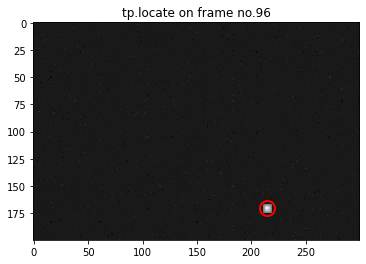

A non-zero value!, namely 1


C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


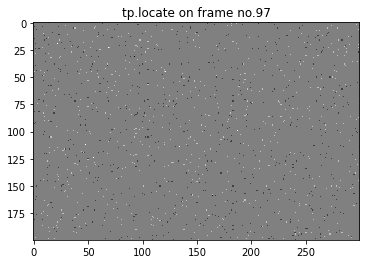

No particles located in this frame!


C:\Users\brugg\Downloads\WPy64-3940\python-3.9.4.amd64\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


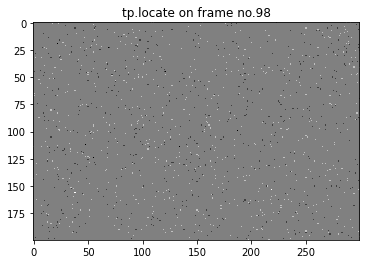

No particles located in this frame!
The total number of landed particles = 45


In [51]:
import trackpy
particlelist = []
for i in np.arange(0,bgcorrected.shape[0]):
    im=plt.imshow(bgcorrected[i,:,:])
    plt.title(f'tp.locate on frame no.{i}')
    f = trackpy.locate(bgcorrected[i,:,:], 25, minmass = 20, invert = False)# 25 = the est. pixel size, minmass = intensity 
    trackpy.annotate(f, bgcorrected[i,:,:]);
    particleframe = len(f['mass'])
    if len(f['mass']) != 0:
        print('A non-zero value!, namely '+str(particleframe))
        particlelist.append(len(f['mass']))
    else:
        print('No particles located in this frame!')

allparticles = sum(particlelist)
print('The total number of landed particles = '+str(allparticles))


Use trackpy.batch on the whole series of frames

In [41]:
f_2 = trackpy.batch(bgcorrected[:,:,:], 25, minmass=20, invert=False, processes='auto')

Frame 98: 0 features


Create dataframe to see information of all particles found(all unique particles!)

In [42]:
f_2

y           x         mass      size       ecc     signal  \
0    18.503151   78.500465   654.776572  3.072076  0.036436  17.250545   
1   129.501385  131.500564   634.441321  3.078386  0.036568  16.594783   
2   109.506947  213.498302   628.135700  3.072785  0.037431  16.483956   
3    22.487106   38.501387   540.873854  3.080648  0.034579  14.115068   
4    79.493453   22.497680   682.081868  3.069041  0.036104  17.932867   
5    68.503081  187.498665   684.243005  3.076938  0.037137  17.917639   
6    98.497188  263.502175   662.249982  3.071750  0.036186  17.355517   
7    72.241597  268.667467  1010.616650  5.088396  0.577992  15.468622   
8   163.502515   36.512884   592.078027  3.077065  0.037523  15.499425   
9    89.496862  217.505710   555.772788  3.072084  0.036825  14.581959   
10   65.510928  220.501237   590.860958  3.069034  0.036870  15.532943   
11   73.500566  104.489861   663.272559  3.073118  0.034508  17.409625   
12  175.508379  174.502622   535.527398  3.073765  0.034443  14.039219   
13   91.496723   66.501844   622.778922  3.077086  0.035462  16.264710   
14   57.490286  229.493610   513.766334  3.071055  0.037491  13.558093   
15  175.497477  238.505818   574.423004  3.072478  0.034203  15.083706   
16  107.601424  197.498672   517.011085  3.006722  0.045093  13.953970   
17  134.488978  234.508859   556.067070  3.073254  0.035317  14.548932   
18  124.489147  104.498494   597.822103  3.077022  0.036886  15.645568   
19  159.504571  285.494402   604.403175  3.075209  0.035273  15.769739   
20  182.503443  106.505910   668.909873  3.072128  0.036641  17.532328   
21  123.502524  171.501700   574.695992  3.070761  0.036676  15.040987   
22   13.498304  216.494191   649.663174  3.073029  0.037137  17.031367   
23  144.501181  211.486498   682.407446  3.075145  0.035510  17.867738   
24  164.500206  244.506691   602.280508  3.071903  0.035837  15.810328   
25   96.507125  151.483168   572.140171  3.070694  0.033963  15.065649   
26   49.495667  223.506397   617.689159  3.072987  0.036332  16.251624   
27   99.495073   73.505338   610.472519  3.075856  0.036952  15.979316   
28   32.499726  184.502245   638.582759  3.071201  0.037201  16.780889   
29   38.501691  280.492161   682.352912  3.079388  0.034259  17.829695   
30   26.492124   88.502934   660.571353  3.077385  0.036060  17.342293   
31   51.499639   16.500980   567.992068  3.067822  0.035065  14.942534   
32  128.498044   82.494133   612.353604  3.070933  0.034837  16.071446   
33  117.490894  272.503035   565.257750  3.071447  0.032762  14.830819   
34  128.504213  252.505857   541.200359  3.073427  0.036689  14.125040   
35  176.508020  160.504421   647.912338  3.075361  0.035815  16.987214   
36  182.496404   39.506164   567.816461  3.072793  0.036404  14.874995   
37  158.498200  265.500977   614.340471  3.072571  0.035407  16.115299   
38   31.498922  268.500565   532.968706  3.074592  0.035224  13.957792   
39  148.498301  227.505199   583.035236  3.076163  0.034346  15.306701   
40  112.498508  203.501903   660.656251  3.072371  0.036014  17.330248   
41  144.506631   73.501285   622.071709  3.075805  0.036069  16.308038   
42   55.502422  109.494589   677.727371  3.072805  0.037081  17.811036   

       raw_mass        ep  frame  
0    798.695127  0.012618      1  
1    781.666034  0.015483      2  
2    762.929868  0.011725      3  
3    664.856517  0.012963      4  
4    834.099326  0.012195      8  
5    838.300685  0.014439     10  
6    811.149196  0.014920     10  
7   1445.980029  0.006543     11  
8    730.646027  0.017563     12  
9    685.000631  0.020609     15  
10   721.629537  0.013357     17  
11   813.486138  0.015640     20  
12   658.253764  0.025823     23  
13   767.947350  0.018091     24  
14   627.528621  0.010667     28  
15   704.855288  0.014725     31  
16   657.993640  0.020672     32  
17   686.985238  0.017713     33  
18   738.623573  0.019291     37  
19   738.685701  0.019289     37  
20   821.689864  0.00